In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load data
print("Loading data...")
df = pd.read_parquet('workspace/data/hackernews_full_data.parquet')
print(f"Loaded {len(df):,} stories")

# Use a sample for faster processing
df_sample = df.sample(n=500000, random_state=42).copy()

Using device: cpu
Loading data...
Loaded 4,902,536 stories


In [2]:
print(df_sample.head(5))

               id               by                time  \
3942193   2488405           icefox 2011-04-27 05:36:18   
3221796  22654492         frereubu 2020-03-22 12:32:51   
35269      151269   jasonlbaptiste 2008-03-31 21:17:01   
2263485   1440203        123icebox 2010-06-17 21:11:46   
3245845  22832574  onetimemanytime 2020-04-10 14:01:09   

                                                       url  score  \
3942193   http://zrusin.blogspot.com/2011/04/apitrace.html      7   
3221796             https://ourworldindata.org/coronavirus      1   
35269                                                 None      1   
2263485  http://www.primarygames.com/arcade/virtualworl...      1   
3245845  https://news.yahoo.com/wuhan-rent-protest-show...      1   

                                                     title  descendants  
3942193  OpenGL and Direct3D crazy GUI debugger via API...          1.0  
3221796  Coronavirus Disease (Covid-19) – Statistics an...          0.0  
35269    The A

In [3]:
# Check the type of the 'time' column
print(df_sample['time'].head())
print(df_sample['time'].dtype)

# Convert to datetime if not already
df_sample['timestamp'] = pd.to_datetime(df_sample['time'], errors='coerce')

# Check for any failed conversions (NaT)
print(df_sample['timestamp'].isnull().sum(), "rows could not be converted to datetime.")
print(df_sample[['time', 'timestamp']].head())




3942193   2011-04-27 05:36:18
3221796   2020-03-22 12:32:51
35269     2008-03-31 21:17:01
2263485   2010-06-17 21:11:46
3245845   2020-04-10 14:01:09
Name: time, dtype: datetime64[ns]
datetime64[ns]
0 rows could not be converted to datetime.
                       time           timestamp
3942193 2011-04-27 05:36:18 2011-04-27 05:36:18
3221796 2020-03-22 12:32:51 2020-03-22 12:32:51
35269   2008-03-31 21:17:01 2008-03-31 21:17:01
2263485 2010-06-17 21:11:46 2010-06-17 21:11:46
3245845 2020-04-10 14:01:09 2020-04-10 14:01:09


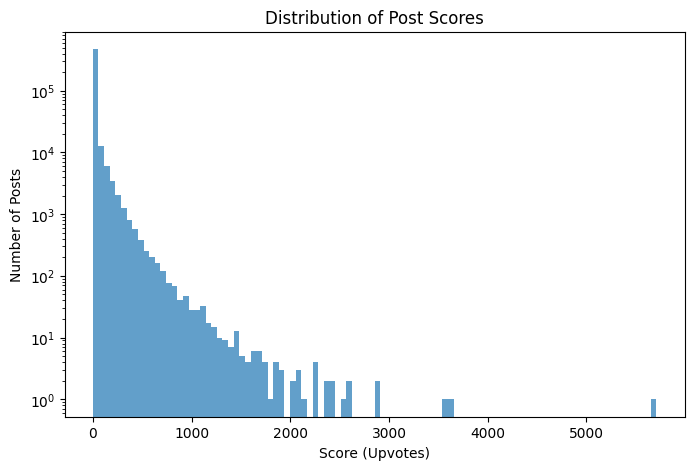

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(df_sample['score'], bins=100, log=True, alpha=0.7)
plt.xlabel('Score (Upvotes)')
plt.ylabel('Number of Posts')
plt.title('Distribution of Post Scores')
plt.show()

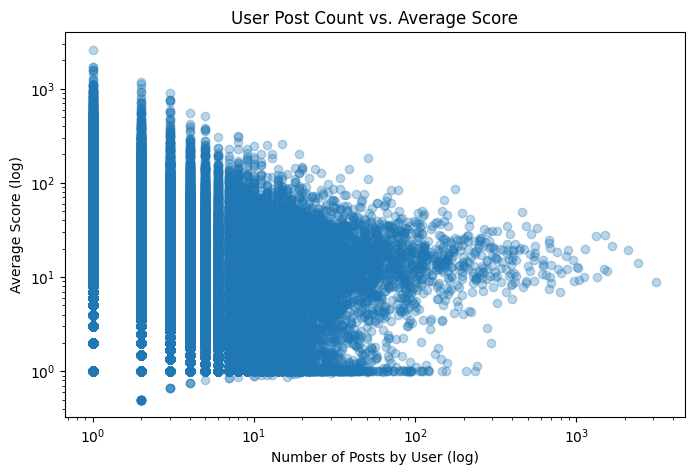

In [5]:
user_post_counts = df_sample.groupby('by')['id'].count()
user_scores = df_sample.groupby('by')['score'].mean()
plt.figure(figsize=(8, 5))
plt.scatter(user_post_counts, user_scores, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Posts by User (log)')
plt.ylabel('Average Score (log)')
plt.title('User Post Count vs. Average Score')
plt.show()

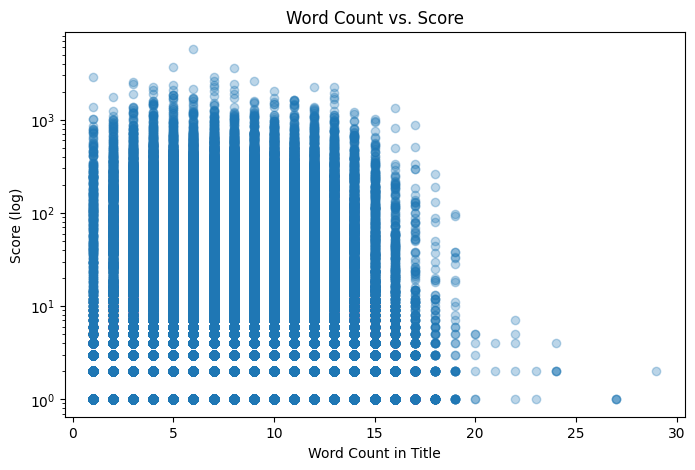

In [6]:
df_sample['word_count'] = df_sample['title'].str.split().str.len()
plt.figure(figsize=(8, 5))
plt.scatter(df_sample['word_count'], df_sample['score'], alpha=0.3)
plt.yscale('log')
plt.xlabel('Word Count in Title')
plt.ylabel('Score (log)')
plt.title('Word Count vs. Score')
plt.show()

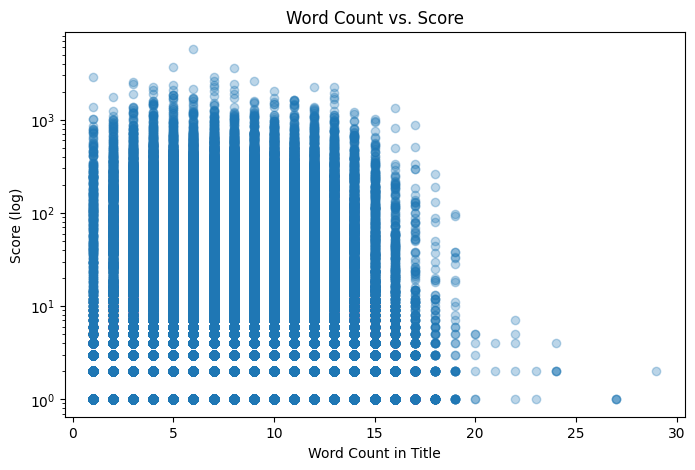

In [7]:
df_sample['word_count'] = df_sample['title'].str.split().str.len()
plt.figure(figsize=(8, 5))
plt.scatter(df_sample['word_count'], df_sample['score'], alpha=0.3)
plt.yscale('log')
plt.xlabel('Word Count in Title')
plt.ylabel('Score (log)')
plt.title('Word Count vs. Score')
plt.show()

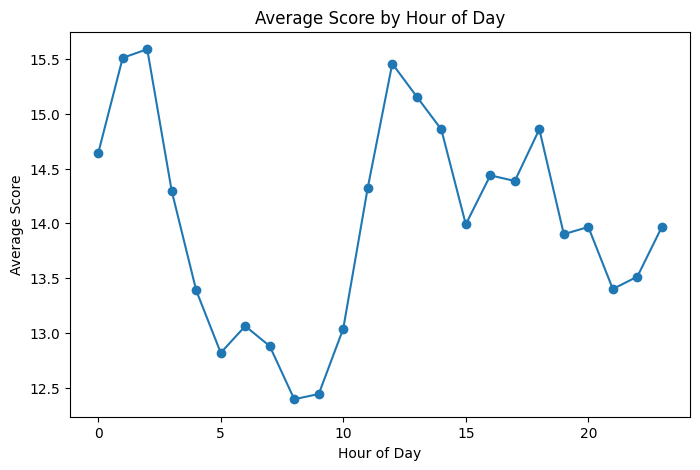

In [8]:
df_sample['hour_of_day'] = df_sample['timestamp'].dt.hour
hourly_scores = df_sample.groupby('hour_of_day')['score'].mean()
plt.figure(figsize=(8, 5))
plt.plot(hourly_scores.index, hourly_scores.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Score')
plt.title('Average Score by Hour of Day')
plt.show()

In [9]:
print("Calculating user and title features...")

# User features
user_post_counts = df_sample.groupby('by')['id'].count().rename('user_post_count')
user_median_scores = df_sample.groupby('by')['score'].median().rename('user_median_score')

# Merge them back into the dataframe
df_featured = df_sample.merge(user_post_counts, on='by', how='left')
df_featured = df_featured.merge(user_median_scores, on='by', how='left')

# Fill missing values
df_featured['user_post_count'] = df_featured['user_post_count'].fillna(1)
df_featured['user_median_score'] = df_featured['user_median_score'].fillna(df_featured['user_median_score'].median())

# Title feature
df_featured['word_count'] = df_featured['title'].str.split().str.len()
df_featured['word_count'] = df_featured['word_count'].fillna(0)

print("Features calculated.")

# Apply log1p transformation to the target variable
df_featured['score_log'] = np.log1p(df_featured['score'])


# --- FIX: Point-in-Time Feature Engineering ---
print("Calculating point-in-time user features to prevent data leakage...")

# 1. Sort dataframe by time to calculate history correctly
df_featured.sort_values('timestamp', inplace=True)

# 2. Calculate user's post history up to the current post
# For a user's first post, this will correctly be 0
df_featured['user_post_count_pt'] = df_featured.groupby('by').cumcount()

# 3. Calculate user's median score based on posts made *before* the current one
# Use expanding median to get a running median for each user
user_expanding_median = df_featured.groupby('by')['score'].expanding().median()

# Drop the user index level and align it back to the main dataframe
df_featured['user_median_score_pt'] = user_expanding_median.reset_index(level=0, drop=True)

# Shift the median score by 1 for each user, so we're only using past data
df_featured['user_median_score_pt'] = df_featured.groupby('by')['user_median_score_pt'].shift(1)

# For a user's first post, fill the now-NaN median score with 0
df_featured['user_median_score_pt'].fillna(0, inplace=True)
print("Point-in-time features calculated.")


# --- Time-based features (with cyclical transformation) ---
print("Adding time-based features...")
df_featured['timestamp'] = pd.to_datetime(df_featured['timestamp'])
df_featured['hour_of_day'] = df_featured['timestamp'].dt.hour
df_featured['day_of_week'] = df_featured['timestamp'].dt.dayofweek

# Cyclical features for time
df_featured['hour_sin'] = np.sin(2 * np.pi * df_featured['hour_of_day']/24)
df_featured['hour_cos'] = np.cos(2 * np.pi * df_featured['hour_of_day']/24)
df_featured['day_sin'] = np.sin(2 * np.pi * df_featured['day_of_week']/7)
df_featured['day_cos'] = np.cos(2 * np.pi * df_featured['day_of_week']/7)
print("Time-based features added.")


# --- NEW: URL (Domain) features ---
from urllib.parse import urlparse
print("Adding URL-based features...")

# Handle missing URLs, assuming they are self-posts
df_featured['url'].fillna('self_post', inplace=True)

def extract_domain(url):
    if url == 'self_post' or url is None:
        return 'self_post'
    try:
        # Remove 'www.' prefix for consistency
        domain = urlparse(url).netloc.replace('www.', '')
        if domain == '': # handles cases like relative links or javascript:
            return 'no_domain'
        return domain
    except Exception:
        return 'parse_error'

df_featured['domain'] = df_featured['url'].apply(extract_domain)

# Identify top domains to prevent too many one-hot features
top_domains = df_featured['domain'].value_counts().nlargest(20).index.tolist()

# Create one-hot encoded features for top domains
for domain in top_domains:
    df_featured[f'domain_{domain}'] = (df_featured['domain'] == domain).astype(int)

# Group other domains into a single feature
df_featured['domain_other'] = (~df_featured['domain'].isin(top_domains) & (df_featured['domain'] != 'self_post')).astype(int)
print(f"Added one-hot features for top {len(top_domains)} domains.")



Calculating user and title features...
Features calculated.
Calculating point-in-time user features to prevent data leakage...


/tmp/ipykernel_61581/247221079.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_featured['user_median_score_pt'].fillna(0, inplace=True)
/tmp/ipykernel_61581/247221079.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

Point-in-time features calculated.
Adding time-based features...
Time-based features added.
Adding URL-based features...
Added one-hot features for top 20 domains.


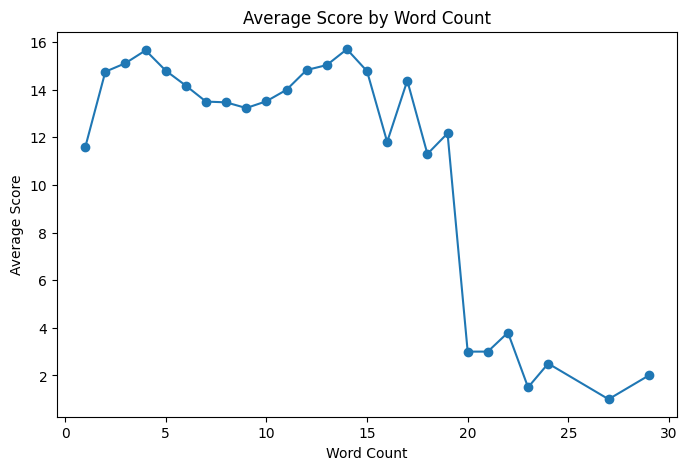

In [11]:
df_sample['word_count'] = df_sample['word_count']
word_count = df_sample.groupby('word_count')['score'].mean()
plt.figure(figsize=(8, 5))
plt.plot(word_count.index, word_count.values, marker='o')
plt.xlabel('Word Count')
plt.ylabel('Average Score')
plt.title('Average Score by Word Count')
plt.show()